In [ ]:
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline\

# 한글 처리 (구글링)
%config InlineBackend.figure_format = 'retina'
 
!apt -qq -y install fonts-nanum
 
import matplotlib.font_manager as fm
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager._rebuild()

fonts-nanum is already the newest version (20170925-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-440
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.


In [ ]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import random as r
import warnings

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from itertools import permutations, combinations
from fbprophet import Prophet
from datetime import datetime

warnings.filterwarnings('ignore')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# 데이터 불러오기

In [ ]:
re_hit_det = pd.read_csv( '/content/drive/My Drive/Colab Notebooks/data_project/은경s/kbreport_hit_detail.csv', sep=',', encoding='cp949' )
re_hit_det = re_hit_det.drop(['Unnamed: 0', 'wRAA'], axis = 1)
re_hit_std = pd.read_csv( '/content/drive/My Drive/Colab Notebooks/data_project/은경s/kbreport_hit_standard.csv', sep=',', encoding='cp949' )
re_hit_std = re_hit_std.drop('Unnamed: 0', axis = 1)
re_hit_main = pd.read_csv( '/content/drive/My Drive/Colab Notebooks/data_project/은경s/kbreport_hit_main.csv', sep=',', encoding='cp949' )
re_hit_main = re_hit_main.drop(['Unnamed: 0', '기대승률', 'WAR'], axis = 1)

In [ ]:
tmp_a = pd.merge( re_hit_main, re_hit_std, on = ['연도', '월', '팀명', '순위', '경기', '득점', '홈런', '도루', '타율'], how = 'outer' )
re_hit = pd.merge( tmp_a, re_hit_det, on = ['연도', '월', '팀명', '순위', '경기', '볼넷%', '삼진%', 'BABIP', '타율', 'OPS'], how = 'outer' )
re_hit.drop(['도실_x', '탸셕'], axis=1, inplace=True)
re_hit.rename(columns={'wOBA_x':'wOBA', '도실_y':'도실', 'wOBA_y':'wRAA'}, inplace = True)
re_hit

,연도,월,순위,팀명,경기,승,무,패,승률,R/G,득점,홈런,도루,볼넷%,삼진%,BABIP,타율,출루율,장타율,OPS,wOBA,타석,타수,안타,단타,2루타,3루타,타점,볼넷,고4,HBP,삼진,희플,희타,병살,볼/삼,ISO,타수/홈런,RC,RC/27,wRC,SPD,wSB,도실,wRAA
0,2015,3,1,롯데,3,3,0,0,1.000,8.00,24,5,4,14.3,23.5,0.379,0.303,0.415,0.525,0.940,0.413,119,99,30,18,7,0,23,17,1,2,28,0,1,1,0.61,0.222,19.80,22.91,8.48,22.45,5.43,0.77,0.413,7.16
1,2015,3,2,두산,2,2,0,0,1.000,6.50,13,4,1,8.3,6.9,0.268,0.297,0.352,0.516,0.868,0.372,72,64,19,14,0,1,13,6,1,0,5,1,1,2,1.20,0.219,16.00,11.45,6.44,10.87,5.37,0.22,0.372,1.62
2,2015,3,3,KIA,2,2,0,0,1.000,5.00,10,4,2,12.3,9.6,0.260,0.283,0.380,0.550,0.930,0.402,73,60,17,10,2,1,10,9,0,1,7,1,3,1,1.29,0.267,15.00,13.61,7.82,13.04,5.88,0.39,0.402,3.66
3,2015,3,4,삼성,3,2,0,1,0.667,5.67,17,3,8,8.0,12.0,0.347,0.319,0.379,0.469,0.848,0.379,125,113,36,25,8,0,17,10,0,1,15,0,1,1,0.67,0.150,37.67,21.79,7.36,19.71,5.63,1.43,0.379,3.65
4,2015,3,5,한화,2,1,0,1,0.500,4.50,9,1,6,13.7,16.8,0.310,0.257,0.385,0.351,0.736,0.348,95,74,19,14,4,0,9,13,0,3,16,1,5,1,0.81,0.094,74.00,12.09,5.18,12.27,4.87,1.08,0.348,0.07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
405,2020,7,6,삼성,19,9,0,10,0.474,5.84,111,19,20,9.5,17.0,0.357,0.310,0.378,0.452,0.830,0.371,757,664,206,153,31,3,105,72,0,5,129,8,16,19,0.56,0.142,34.95,113.21,6.06,114.14,5.27,3.98,0.371,16.88
406,2020,7,7,롯데,20,9,0,11,0.450,5.40,108,19,17,9.1,15.6,0.316,0.281,0.354,0.413,0.767,0.346,788,693,195,142,34,0,103,72,1,9,123,6,13,22,0.58,0.132,36.47,101.59,5.09,100.27,4.50,3.46,0.346,-0.98
407,2020,7,8,LG,20,8,1,11,0.421,5.50,110,23,8,8.7,17.3,0.295,0.263,0.338,0.420,0.758,0.339,790,697,183,124,31,5,104,69,2,13,137,5,11,16,0.50,0.157,30.30,100.38,4.97,96.08,5.37,1.91,0.339,-5.42
408,2020,7,9,Hero,21,8,0,13,0.381,4.86,102,21,18,10.3,18.1,0.316,0.274,0.354,0.416,0.770,0.346,814,711,195,140,30,4,97,84,2,8,147,8,11,20,0.57,0.142,33.86,107.66,5.27,104.16,5.16,3.65,0.346,-0.43


In [ ]:
re_pit_main = pd.read_csv( '/content/drive/My Drive/Colab Notebooks/data_project/은경s/kbreport_pit_main.csv', sep=',', encoding='cp949' )
re_pit_main = re_pit_main.drop('Unnamed: 0', axis = 1)
re_pit_std = pd.read_csv( '/content/drive/My Drive/Colab Notebooks/data_project/은경s/kbreport_pit_standard.csv', sep=',', encoding='cp949' )
re_pit_std = re_pit_std.drop('Unnamed: 0', axis = 1)
re_pit_std['이닝'] = np.trunc(re_pit_std['이닝']) + re_pit_std['이닝']*10 % 10 / 3
re_pit_det = pd.read_csv( '/content/drive/My Drive/Colab Notebooks/data_project/은경s/kbreport_pit_detail.csv', sep=',', encoding='cp949' )
re_pit_det = re_pit_det.drop('Unnamed: 0', axis = 1)
re_pit_det['삼/볼'][re_pit_det['삼/볼'] == '-'] = '0'
re_pit_det['삼/볼'] = re_pit_det['삼/볼'].map(lambda x : float(x))

In [ ]:
tmp = pd.merge( re_pit_main, re_pit_std, on = ['연도', '월', '팀명', '경기', '실점', '자책'], how = 'outer' ).drop('순위_y', axis=1)
tmp.rename(columns = {'순위_x':'순위'}, inplace=True)
re_pit=pd.merge(tmp, re_pit_det.drop('순위', axis=1), on =['연도', '월', '팀명', '경기', 'BABIP', 'LOB%', 'RA9-WAR', 'FIP', 'kFIP', 'WAR', 'QS', 'ERA'], how='outer')
re_pit.drop(['승', '패'], axis =1, inplace=True)
re_pit["승률"] = re_pit["승률"].apply( lambda x : float( x.replace("-", "0" )) )
re_pit = re_pit.astype({'승률':'float'})
re_pit

,연도,월,순위,팀명,경기,팀승,팀무,팀패,승률,RA/G,실점,자책,피홈런,볼넷%,삼진%,BABIP,LOB%,ERA,RA9-WAR,FIP,kFIP,WAR,세,홀드,블론,QS,이닝,타자,안타,2루타,3루타,홈런,삼진,볼넷,고4,HBP,폭투,보크,PK,도루,도실,완투,완봉,삼진/9,볼넷/9,홈런/9,삼/볼,피안타율,피출루율,피장타율,피OPS,WHIP
0,2015,3,1,두산,2,2,0,0,1.000,2.50,5,5,0,7.9,11.8,0.300,80.0,2.50,0.76,3.78,4.01,0.39,1,3,0,1,18.000000,76,18,3,0,0,9,6,0,1,0,1,0,2,2,0,0,4.50,3.00,0.00,1.50,0.269,0.329,0.313,0.642,1.33
1,2015,3,2,KIA,2,2,0,0,1.000,3.50,7,7,0,9.1,15.6,0.386,75.9,3.50,0.96,3.45,3.55,0.40,1,1,0,1,18.000000,77,22,7,1,0,12,7,0,0,1,0,0,3,1,0,0,6.00,3.50,0.00,1.71,0.324,0.382,0.456,0.837,1.61
2,2015,3,3,롯데,3,3,0,0,1.000,4.67,14,14,2,14.8,16.5,0.347,74.1,5.04,0.76,5.06,5.21,0.49,1,5,0,2,25.000000,115,28,4,0,2,19,17,2,1,0,0,0,2,3,0,0,6.84,6.12,0.72,1.12,0.295,0.404,0.400,0.804,1.80
3,2015,3,4,삼성,3,2,0,1,0.667,4.67,14,14,1,12.2,18.3,0.263,63.6,4.67,0.64,4.21,4.30,0.39,1,3,0,1,27.000000,115,21,7,1,1,21,14,0,1,0,0,1,1,3,0,0,7.00,4.67,0.33,1.50,0.216,0.319,0.340,0.659,1.30
4,2015,3,5,한화,2,1,0,1,0.500,4.00,8,8,2,11.8,16.5,0.228,78.5,3.54,1.08,5.29,5.46,0.22,1,2,1,1,20.333333,85,15,4,0,2,14,10,0,2,1,0,2,2,0,0,0,6.20,4.43,0.89,1.40,0.205,0.318,0.342,0.660,1.23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
405,2020,7,6,삼성,19,9,0,10,0.474,5.37,102,95,19,9.3,15.9,0.310,66.8,5.11,3.07,5.05,5.13,1.30,2,16,6,7,167.333333,731,176,27,3,19,116,68,3,10,7,2,2,6,6,1,0,6.24,3.66,1.02,1.71,0.276,0.353,0.417,0.770,1.46
406,2020,7,7,롯데,20,9,0,11,0.450,5.95,119,102,25,8.6,17.3,0.318,64.6,5.20,2.19,5.12,5.09,1.58,5,15,2,7,176.666667,788,198,31,2,25,136,68,3,6,15,0,0,15,4,0,0,6.93,3.46,1.27,2.00,0.284,0.349,0.441,0.790,1.51
407,2020,7,8,LG,20,8,1,11,0.421,5.95,119,104,24,7.0,16.6,0.354,66.8,5.24,2.85,4.90,4.87,2.54,2,6,5,12,178.666667,801,228,42,2,24,133,56,2,7,5,2,1,10,11,0,0,6.70,2.82,1.21,2.38,0.315,0.366,0.478,0.843,1.59
408,2020,7,9,Hero,21,8,0,13,0.381,6.62,139,131,23,9.4,16.3,0.352,63.0,6.41,0.39,5.19,5.23,1.23,5,13,3,4,184.000000,847,232,33,4,23,138,80,0,9,10,0,1,12,8,0,0,6.75,3.91,1.12,1.72,0.309,0.380,0.455,0.836,1.70


In [ ]:
kbo_wlr = pd.read_csv( '/content/drive/My Drive/Colab Notebooks/data_project/은경s/kbo_2001_2019_wlr.csv', sep=',', encoding='cp949' )
kbo_wlr = kbo_wlr.drop('Unnamed: 0', axis = 1)
kbo_wlr = kbo_wlr[kbo_wlr['연도']<2020]
kbo_wlr['팀명'][kbo_wlr['팀명']=='히어로즈'] = '키움'
kbo_wlr['팀명'][kbo_wlr['팀명']=='넥센'] = '키움'
kbo_hit = pd.read_csv( '/content/drive/My Drive/Colab Notebooks/data_project/은경s/kbo_2001_2020_hitter.csv', sep=',', encoding='cp949' )
kbo_hit = kbo_hit.drop('Unnamed: 0', axis = 1)
kbo_hit = kbo_hit[kbo_hit['연도']<2020]
kbo_hit['팀명'][kbo_hit['팀명']=='히어로즈'] = '키움'
kbo_hit['팀명'][kbo_hit['팀명']=='넥센'] = '키움'
kbo_pit = pd.read_csv( '/content/drive/My Drive/Colab Notebooks/data_project/은경s/kbo_2001_2020_pitcher.csv', sep=',', encoding='cp949' )
kbo_pit = kbo_pit.drop('Unnamed: 0', axis = 1)
kbo_pit = kbo_pit[kbo_pit['연도']<2020]
kbo_pit['팀명'][kbo_pit['팀명']=='히어로즈'] = '키움'
kbo_pit['팀명'][kbo_pit['팀명']=='넥센'] = '키움'
kbo_def = pd.read_csv( '/content/drive/My Drive/Colab Notebooks/data_project/은경s/kbo_2001_2020_defense.csv', sep=',', encoding='cp949' )
kbo_def = kbo_def.drop('Unnamed: 0', axis = 1)
kbo_def = kbo_def[kbo_def['연도']<2020]
kbo_def['팀명'][kbo_def['팀명']=='히어로즈'] = '키움'
kbo_def['팀명'][kbo_def['팀명']=='넥센'] = '키움'
kbo_run = pd.read_csv( '/content/drive/My Drive/Colab Notebooks/data_project/은경s/kbo_2001_2020_runner.csv', sep=',', encoding='cp949' )
kbo_run = kbo_run.drop('Unnamed: 0', axis = 1)
kbo_run = kbo_run[kbo_run['연도']<2020]
kbo_run['팀명'][kbo_run['팀명']=='히어로즈'] = '키움'
kbo_run['팀명'][kbo_run['팀명']=='넥센'] = '키움'

# 정규화

In [ ]:
re_pit.dtypes

연도           int64
월            int64
순위           int64
팀명          object
경기           int64
팀승           int64
팀무           int64
팀패           int64
승률         float64
RA/G       float64
실점           int64
자책           int64
피홈런          int64
볼넷%        float64
삼진%        float64
BABIP      float64
LOB%       float64
ERA        float64
RA9-WAR    float64
FIP        float64
kFIP       float64
WAR        float64
세            int64
홀드           int64
블론           int64
QS           int64
이닝         float64
타자           int64
안타           int64
2루타          int64
3루타          int64
홈런           int64
삼진           int64
볼넷           int64
고4           int64
HBP          int64
폭투           int64
보크           int64
PK           int64
도루           int64
도실           int64
완투           int64
완봉           int64
삼진/9       float64
볼넷/9       float64
홈런/9       float64
삼/볼        float64
피안타율       float64
피출루율       float64
피장타율       float64
피OPS       float64
WHIP       float64
dtype: objec

In [ ]:
re_pit.describe()

,연도,월,순위,경기,팀승,팀무,팀패,승률,RA/G,실점,자책,피홈런,볼넷%,삼진%,BABIP,LOB%,ERA,RA9-WAR,FIP,kFIP,WAR,세,홀드,블론,QS,이닝,타자,안타,2루타,3루타,홈런,삼진,볼넷,고4,HBP,폭투,보크,PK,도루,도실,완투,완봉,삼진/9,볼넷/9,홈런/9,삼/볼,피안타율,피출루율,피장타율,피OPS,WHIP
count,410.000000,410.000000,410.000000,410.000000,410.000000,410.000000,410.000000,410.000000,410.000000,410.000000,410.000000,410.000000,410.00000,410.000000,410.000000,410.000000,410.000000,410.000000,410.000000,410.000000,410.000000,410.000000,410.000000,410.000000,410.000000,410.000000,410.00000,410.000000,410.000000,410.000000,410.000000,410.000000,410.000000,410.000000,410.000000,410.000000,410.000000,410.000000,410.000000,410.000000,410.000000,410.000000,410.000000,410.000000,410.000000,410.000000,410.000000,410.000000,410.000000,410.000000,410.000000
mean,2017.195122,6.463415,5.500000,19.204878,9.509756,0.185366,9.509756,0.500141,5.189390,100.941463,92.458537,19.456098,8.66000,17.997805,0.320317,69.575366,4.801415,3.340805,4.886195,4.883073,2.139195,4.185366,7.602439,2.158537,7.529268,170.475610,756.20000,187.041463,33.119512,2.843902,19.456098,134.609756,65.563415,2.236585,10.963415,9.114634,0.580488,1.126829,13.109756,6.092683,0.275610,0.114634,7.150317,3.463390,1.033902,2.165317,0.277846,0.349185,0.423829,0.772968,1.471415
std,1.567074,2.145075,2.875791,7.822416,4.660205,0.425105,4.646018,0.178364,1.212161,45.607623,42.069967,9.671336,1.89408,2.740214,0.034140,6.302901,1.176738,2.179648,0.746216,0.804280,1.388261,2.599564,4.567933,1.696174,4.188746,69.465562,309.45679,79.172837,15.335143,2.293826,9.671336,56.484534,29.769073,2.164422,6.041513,5.259434,0.873186,1.256188,7.449268,3.505664,0.536802,0.348283,0.996123,0.828124,0.389572,0.710110,0.029988,0.031265,0.056613,0.082870,0.190151
min,2015.000000,3.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,6.900000,0.150000,41.700000,0.000000,-1.780000,2.290000,2.160000,-0.680000,0.000000,0.000000,0.000000,0.000000,8.000000,33.00000,4.000000,0.000000,0.000000,0.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.810000,0.000000,0.000000,0.000000,0.129000,0.206000,0.138000,0.357000,0.750000
25%,2016.000000,5.000000,3.000000,19.000000,7.000000,0.000000,7.000000,0.409000,4.525000,82.250000,75.000000,14.000000,7.50000,16.225000,0.303250,65.900000,4.152500,1.627500,4.470000,4.392500,1.087500,2.000000,4.000000,1.000000,4.250000,165.000000,707.50000,165.250000,27.000000,1.000000,14.000000,115.250000,53.000000,0.000000,7.000000,6.000000,0.000000,0.000000,8.000000,3.000000,0.000000,0.000000,6.512500,2.970000,0.790000,1.780000,0.263000,0.331250,0.395250,0.731000,1.360000
50%,2017.000000,6.000000,5.500000,23.000000,11.000000,0.000000,10.000000,0.500000,5.200000,115.000000,105.000000,21.000000,8.65000,18.000000,0.323000,69.100000,4.810000,3.315000,4.930000,4.920000,2.075000,4.000000,7.000000,2.000000,8.000000,201.000000,890.00000,215.000000,36.000000,3.000000,21.000000,153.000000,71.000000,2.000000,11.000000,9.000000,0.000000,1.000000,13.000000,6.000000,0.000000,0.000000,7.110000,3.450000,1.020000,2.060000,0.280000,0.352000,0.424000,0.773000,1.480000
75%,2018.000000,8.000000,8.000000,25.000000,13.000000,0.000000,13.000000,0.600000,5.942500,130.000000,120.000000,26.750000,9.70000,19.400000,0.339000,72.675000,5.530000,4.880000,5.297500,5.340000,3.115000,6.000000,11.000000,3.000000,11.000000,217.833333,960.75000,241.000000,44.000000,4.000000,26.750000,173.000000,87.000000,3.000000,15.000000,13.000000,1.000000,2.000000,18.000000,8.000000,0.000000,0.000000,7.745000,3.910000,1.247500,2.430000,0.296000,0.369000,0.458000,0.825000,1.590000
max,2020.000000,10.000000,10.000000,27.000000,20.000000,2.000000,20.000000,1.000000,10.000000,193.000000,180.000000,42.000000,19.00000,31.700000,0.455000,115.400000,8.510000,8.970000,9.620000,9.870000,6.020000,13.000000,24.000000,8.000000,19.000000,244.000000,1137.00000,302.000000,73.000000,10.000000,42.000000,216.000000,133.000000,13.000000,28.000000,29.00000

In [ ]:
scaler = preprocessing.MinMaxScaler()

In [ ]:
re_pit_edit = re_pit
re_pit_edit['승/경기'] = re_pit['팀승'] / re_pit['경기']
re_pit_edit['무/경기'] = re_pit['팀무'] / re_pit['경기']
re_pit_edit['패/경기'] = re_pit['팀패'] / re_pit['경기']
re_pit_edit.drop(['팀승', '팀무', '팀패'], axis=1, inplace=True)
re_pit_edit

,연도,월,순위,팀명,경기,승률,RA/G,실점,자책,피홈런,볼넷%,삼진%,BABIP,LOB%,ERA,RA9-WAR,FIP,kFIP,WAR,세,홀드,블론,QS,이닝,타자,안타,2루타,3루타,홈런,삼진,볼넷,고4,HBP,폭투,보크,PK,도루,도실,완투,완봉,삼진/9,볼넷/9,홈런/9,삼/볼,피안타율,피출루율,피장타율,피OPS,WHIP,승/경기,무/경기,패/경기
0,2015,3,1,두산,2,1.000,2.50,5,5,0,7.9,11.8,0.300,80.0,2.50,0.76,3.78,4.01,0.39,1,3,0,1,18.000000,76,18,3,0,0,9,6,0,1,0,1,0,2,2,0,0,4.50,3.00,0.00,1.50,0.269,0.329,0.313,0.642,1.33,1.000000,0.00,0.000000
1,2015,3,2,KIA,2,1.000,3.50,7,7,0,9.1,15.6,0.386,75.9,3.50,0.96,3.45,3.55,0.40,1,1,0,1,18.000000,77,22,7,1,0,12,7,0,0,1,0,0,3,1,0,0,6.00,3.50,0.00,1.71,0.324,0.382,0.456,0.837,1.61,1.000000,0.00,0.000000
2,2015,3,3,롯데,3,1.000,4.67,14,14,2,14.8,16.5,0.347,74.1,5.04,0.76,5.06,5.21,0.49,1,5,0,2,25.000000,115,28,4,0,2,19,17,2,1,0,0,0,2,3,0,0,6.84,6.12,0.72,1.12,0.295,0.404,0.400,0.804,1.80,1.000000,0.00,0.000000
3,2015,3,4,삼성,3,0.667,4.67,14,14,1,12.2,18.3,0.263,63.6,4.67,0.64,4.21,4.30,0.39,1,3,0,1,27.000000,115,21,7,1,1,21,14,0,1,0,0,1,1,3,0,0,7.00,4.67,0.33,1.50,0.216,0.319,0.340,0.659,1.30,0.666667,0.00,0.333333
4,2015,3,5,한화,2,0.500,4.00,8,8,2,11.8,16.5,0.228,78.5,3.54,1.08,5.29,5.46,0.22,1,2,1,1,20.333333,85,15,4,0,2,14,10,0,2,1,0,2,2,0,0,0,6.20,4.43,0.89,1.40,0.205,0.318,0.342,0.660,1.23,0.500000,0.00,0.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
405,2020,7,6,삼성,19,0.474,5.37,102,95,19,9.3,15.9,0.310,66.8,5.11,3.07,5.05,5.13,1.30,2,16,6,7,167.333333,731,176,27,3,19,116,68,3,10,7,2,2,6,6,1,0,6.24,3.66,1.02,1.71,0.276,0.353,0.417,0.770,1.46,0.473684,0.00,0.526316
406,2020,7,7,롯데,20,0.450,5.95,119,102,25,8.6,17.3,0.318,64.6,5.20,2.19,5.12,5.09,1.58,5,15,2,7,176.666667,788,198,31,2,25,136,68,3,6,15,0,0,15,4,0,0,6.93,3.46,1.27,2.00,0.284,0.349,0.441,0.790,1.51,0.450000,0.00,0.550000
407,2020,7,8,LG,20,0.421,5.95,119,104,24,7.0,16.6,0.354,66.8,5.24,2.85,4.90,4.87,2.54,2,6,5,12,178.666667,801,228,42,2,24,133,56,2,7,5,2,1,10,11,0,0,6.70,2.82,1.21,2.38,0.315,0.366,0.478,0.843,1.59,0.400000,0.05,0.550000
408,2020,7,9,Hero,21,0.381,6.62,139,131,23,9.4,16.3,0.352,63.0,6.41,0.39,5.19,5.23,1.23,5,13,3,4,184.000000,847,232,33,4,23,138,80,0,9,10,0,1,12,8,0,0,6.75,3.91,1.12,1.72,0.309,0.380,0.455,0.836,1.70,0.380952,0.00,0.619048


In [ ]:
cols = re_pit_edit.columns[4:]
X = re_pit_edit[ cols ].values
preprocess_X = scaler.fit_transform( X.astype(float) )
re_pit_edit[ cols ] = preprocess_X
re_pit_edit

,연도,월,순위,팀명,경기,승률,RA/G,실점,자책,피홈런,볼넷%,삼진%,BABIP,LOB%,ERA,RA9-WAR,FIP,kFIP,WAR,세,홀드,블론,QS,이닝,타자,안타,2루타,3루타,홈런,삼진,볼넷,고4,HBP,폭투,보크,PK,도루,도실,완투,완봉,삼진/9,볼넷/9,홈런/9,삼/볼,피안타율,피출루율,피장타율,피OPS,WHIP,승/경기,무/경기,패/경기
0,2015,3,1,두산,0.038462,1.000,0.250,0.025907,0.027778,0.000000,0.415789,0.197581,0.491803,0.519674,0.293772,0.236279,0.203274,0.239948,0.159701,0.076923,0.125000,0.000,0.052632,0.042373,0.038949,0.046980,0.041096,0.0,0.000000,0.018957,0.045113,0.000000,0.035714,0.000000,0.2,0.000000,0.047619,0.117647,0.000000,0.0,0.216667,0.37500,0.000000,0.214286,0.578512,0.510373,0.361570,0.416667,0.449612,1.000000,0.00,0.000000
1,2015,3,2,KIA,0.038462,1.000,0.350,0.036269,0.038889,0.000000,0.478947,0.350806,0.773770,0.464043,0.411281,0.254884,0.158254,0.180285,0.161194,0.076923,0.041667,0.000,0.052632,0.042373,0.039855,0.060403,0.095890,0.1,0.000000,0.033175,0.052632,0.000000,0.000000,0.034483,0.0,0.000000,0.071429,0.058824,0.000000,0.0,0.408974,0.43750,0.000000,0.244286,0.805785,0.730290,0.657025,0.701754,0.666667,1.000000,0.00,0.000000
2,2015,3,3,롯데,0.076923,1.000,0.467,0.072539,0.077778,0.047619,0.778947,0.387097,0.645902,0.439620,0.592244,0.236279,0.377899,0.395590,0.174627,0.076923,0.208333,0.000,0.105263,0.072034,0.074275,0.080537,0.054795,0.0,0.047619,0.066351,0.127820,0.153846,0.035714,0.000000,0.0,0.000000,0.047619,0.176471,0.000000,0.0,0.516667,0.76500,0.240000,0.160000,0.685950,0.821577,0.541322,0.653509,0.813953,1.000000,0.00,0.000000
3,2015,3,4,삼성,0.076923,0.667,0.467,0.072539,0.077778,0.023810,0.642105,0.459677,0.370492,0.297151,0.548766,0.225116,0.261937,0.277562,0.159701,0.076923,0.125000,0.000,0.052632,0.080508,0.074275,0.057047,0.095890,0.1,0.023810,0.075829,0.105263,0.000000,0.035714,0.000000,0.0,0.142857,0.023810,0.176471,0.000000,0.0,0.537179,0.58375,0.110000,0.214286,0.359504,0.468880,0.417355,0.441520,0.426357,0.666667,0.00,0.333333
4,2015,3,5,한화,0.038462,0.500,0.400,0.041451,0.044444,0.047619,0.621053,0.387097,0.255738,0.499322,0.415981,0.266047,0.409277,0.428016,0.134328,0.076923,0.083333,0.125,0.052632,0.052260,0.047101,0.036913,0.054795,0.0,0.047619,0.042654,0.075188,0.000000,0.071429,0.034483,0.0,0.285714,0.047619,0.000000,0.000000,0.0,0.434615,0.55375,0.296667,0.200000,0.314050,0.464730,0.421488,0.442982,0.372093,0.500000,0.00,0.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
405,2020,7,6,삼성,0.692308,0.474,0.537,0.528497,0.527778,0.452381,0.489474,0.362903,0.524590,0.340570,0.600470,0.451163,0.376535,0.385214,0.295522,0.153846,0.666667,0.750,0.368421,0.675141,0.632246,0.577181,0.369863,0.3,0.452381,0.526066,0.511278,0.230769,0.357143,0.241379,0.4,0.285714,0.142857,0.352941,0.333333,0.0,0.439744,0.45750,0.340000,0.244286,0.607438,0.609959,0.576446,0.603801,0.550388,0.473684,0.00,0.526316
406,2020,7,7,롯데,0.730769,0.450,0.595,0.616580,0.566667,0.595238,0.452632,0.419355,0.550820,0.310719,0.611046,0.369302,0.386085,0.380026,0.337313,0.384615,0.625000,0.250,0.368421,0.714689,0.683877,0.651007,0.424658,0.2,0.595238,0.620853,0.511278,0.230769,0.214286,0.517241,0.0,0.000000,0.357143,0.235294,0.000000,0.0,0.528205,0.43250,0.423333,0.285714,0.640496,0.593361,0.626033,0.633041,0.589147,0.450000,0.00,0.550000
407,2020,7,8,LG,0.730769,0.421,0.595,0.616580,0.577778,0.571429,0.368421,0.391129,0.668852,0.340570,0.615746,0.430698,0.356071,0.351492,0.480597,0.153846,0.250000,0.625,0.631579,0.723164,0.695652,0.751678,0.575342,0.2,0.571429,0.606635,0.421053,0.153846,0.250000,0.172414,0.4,0.142857,0.238095,0.647059,0.000000,0.0,0.498718,0.35250,0.403333,0.340000,0.768595,0.663900,0.702479,0.710526,0.651163,0.400000,0.05,0.550000
408,2020,7,9,Hero,0.769231,0.381,0.662,0.720207,0.727778,0.547619,0.494737,0.379032,0.662295,0.289009,0.753231,0.201860,0.395634,0.398184,0.285075,0.384615,0.541667,0.375,0.210526,0.745763,0.737319,0.765101,0.452055,0.4,0.547619,0.630332,0.6015

# 상관계수

## KBREPORT

### 공격


In [ ]:
re_hit["승률"] = re_hit["승률"].apply( lambda x : float( x.replace("-", "0" )) )
re_hit["타수/홈런"] = re_hit["타수/홈런"].apply( lambda x : float( x.replace("-", "0" )) )

In [ ]:
re_hit = re_hit.astype({'승률':'float'}, {'타수/홈런':'float'})

In [ ]:
# 강의
def corrcoefRate( x, y ) :
  ttmp = np.corrcoef( x, y )
  # 2x2 배열(행렬)인 경우에만 해당 (-1이란 값은)
  v    = np.sum(np.tril( ttmp, k=-1 ))
  return {
      '요소'  : col,
      'value' : v*v, 
      'sign'  : '+' if v>0 else '-'
  }

cols = re_hit.columns[4:]
for col in cols :
  print( corrcoefRate( re_hit[col], re_hit['승률'] ) )

{'요소': '경기', 'value': 4.443304377224734e-06, 'sign': '-'}
{'요소': '승', 'value': 0.15551928921361877, 'sign': '+'}
{'요소': '무', 'value': 5.867892049906054e-10, 'sign': '-'}
{'요소': '패', 'value': 0.15928911835792756, 'sign': '-'}
{'요소': '승률', 'value': 1.0, 'sign': '+'}
{'요소': 'R/G', 'value': 0.15926080175024404, 'sign': '+'}
{'요소': '득점', 'value': 0.02658038824122776, 'sign': '+'}
{'요소': '홈런', 'value': 0.021550311184848694, 'sign': '+'}
{'요소': '도루', 'value': 0.009300971758664655, 'sign': '+'}
{'요소': '볼넷%', 'value': 0.07545279662467458, 'sign': '+'}
{'요소': '삼진%', 'value': 0.060690930948991986, 'sign': '-'}
{'요소': 'BABIP', 'value': 0.01359200364689322, 'sign': '+'}
{'요소': '타율', 'value': 0.0618271341995364, 'sign': '+'}
{'요소': '출루율', 'value': 0.12401571813387294, 'sign': '+'}
{'요소': '장타율', 'value': 0.10885550256074726, 'sign': '+'}
{'요소': 'OPS', 'value': 0.12744964658176033, 'sign': '+'}
{'요소': 'wOBA', 'value': 0.12795118151004398, 'sign': '+'}
{'요소': '타석', 'value': 0.00029950599689770337, 'sig

### 투수

In [ ]:
def corrcoefRate( x, y ) :
  tmp = np.corrcoef( x, y )
  # 2x2 배열(행렬)인 경우에만 해당 (-1이란 값은)
  v    = np.sum(np.tril( tmp, k=-1 ))
  return {
      '요소'  : col,
      'value' : v*v, 
      'sign'  : '+' if v>0 else '-'
  }

cols = re_pit.columns[4:]
for col in cols :
  print( corrcoefRate( re_pit[col], re_pit['승률'] ) )

{'요소': '경기', 'value': 4.4433043772246395e-06, 'sign': '-'}
{'요소': '승률', 'value': 1.0, 'sign': '+'}
{'요소': 'RA/G', 'value': 0.32272421237956234, 'sign': '-'}
{'요소': '실점', 'value': 0.03352772456205452, 'sign': '-'}
{'요소': '자책', 'value': 0.030055498199843506, 'sign': '-'}
{'요소': '피홈런', 'value': 0.017570767425358236, 'sign': '-'}
{'요소': '볼넷%', 'value': 0.0929762995062717, 'sign': '-'}
{'요소': '삼진%', 'value': 0.06804554495048629, 'sign': '+'}
{'요소': 'BABIP', 'value': 0.052408247387773964, 'sign': '-'}
{'요소': 'LOB%', 'value': 0.23551826283780614, 'sign': '+'}
{'요소': 'ERA', 'value': 0.25736113083671963, 'sign': '-'}
{'요소': 'RA9-WAR', 'value': 0.14766270259055334, 'sign': '+'}
{'요소': 'FIP', 'value': 0.19276583066975056, 'sign': '-'}
{'요소': 'kFIP', 'value': 0.1958007052445251, 'sign': '-'}
{'요소': 'WAR', 'value': 0.07057425938402155, 'sign': '+'}
{'요소': '세', 'value': 0.10504058866011916, 'sign': '+'}
{'요소': '홀드', 'value': 0.05832527379099861, 'sign': '+'}
{'요소': '블론', 'value': 0.00800696637784243

In [ ]:
tmp = re_pit.drop(columns=['연도','월', '팀명', '순위'])
tmp.dtypes

경기         float64
승률         float64
RA/G       float64
실점         float64
자책         float64
피홈런        float64
볼넷%        float64
삼진%        float64
BABIP      float64
LOB%       float64
ERA        float64
RA9-WAR    float64
FIP        float64
kFIP       float64
WAR        float64
세          float64
홀드         float64
블론         float64
QS         float64
이닝         float64
타자         float64
안타         float64
2루타        float64
3루타        float64
홈런         float64
삼진         float64
볼넷         float64
고4         float64
HBP        float64
폭투         float64
보크         float64
PK         float64
도루         float64
도실         float64
완투         float64
완봉         float64
삼진/9       float64
볼넷/9       float64
홈런/9       float64
삼/볼        float64
피안타율       float64
피출루율       float64
피장타율       float64
피OPS       float64
WHIP       float64
승/경기       float64
무/경기       float64
패/경기       float64
dtype: object

In [ ]:
model = sm.OLS( tmp['승률'], sm.add_constant( tmp['ERA'] ) )
result = model.fit()
print( result.summary() )

                            OLS Regression Results                            
Dep. Variable:                     승률   R-squared:                       0.257
Model:                            OLS   Adj. R-squared:                  0.256
Method:                 Least Squares   F-statistic:                     141.4
Date:                Thu, 30 Jul 2020   Prob (F-statistic):           3.36e-28
Time:                        08:15:21   Log-Likelihood:                 186.54
No. Observations:                 410   AIC:                            -369.1
Df Residuals:                     408   BIC:                            -361.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.8693      0.032     27.196      0.0

In [ ]:
corr_tmp = np.corrcoef(tmp.values.T)
corr_tmp.shape

(48, 48)

In [ ]:
plt.figure(figsize=(25,25))
sns.heatmap(corr_tmp, cbar=True, annot=True, square=True, fmt='.2f',
            annot_kws={'size':10}, yticklabels=tmp.columns, xticklabels=tmp.columns)
plt.show()

Output hidden; open in https://colab.research.google.com to view.

## kbo 01-19 분석

### 타자

In [ ]:
tmp1 = kbo_wlr.loc[:, ['연도', '팀명', '승률']]
tmp1

,연도,팀명,승률
0,2001,두산,0.508
1,2001,삼성,0.609
2,2001,현대,0.558
3,2001,한화,0.473
4,2001,KIA,0.469
...,...,...,...
159,2019,KT,0.500
160,2019,KIA,0.437
161,2019,삼성,0.420
162,2019,한화,0.403


In [ ]:
kbo_hit_df = pd.merge(tmp1, kbo_hit, on=['연도', '팀명'], how='outer')
kbo_hit_df

,연도,팀명,승률,타율,경기,타석,타수,득점,안타,2루타,3루타,홈런,루타,타점,희생번트,희생플라이,볼넷,고의4구,사구,삼진,병살타,장타율,출루율,OPS,멀티히트,득점권타율,대타타율
0,2001,두산,0.508,0.276,133,5303,4583,732,1266,221,26,130,1929,688,54,46,560,27,60,697,116,0.421,0.359,0.780,133,0.278,0.163
1,2001,삼성,0.609,0.277,133,5280,4553,739,1262,244,21,162,2034,695,69,42,520,27,95,814,111,0.447,0.360,0.807,133,0.267,0.223
2,2001,현대,0.558,0.268,133,5225,4445,711,1192,166,20,169,1905,667,77,29,598,14,76,911,109,0.429,0.362,0.791,133,0.279,0.232
3,2001,한화,0.473,0.275,133,5259,4556,659,1255,211,15,148,1940,628,75,34,549,28,45,877,106,0.426,0.357,0.783,133,0.265,0.233
4,2001,KIA,0.469,0.278,133,5189,4542,683,1263,221,17,142,1944,637,51,43,497,21,56,774,129,0.428,0.353,0.781,133,0.272,0.225
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
159,2019,KT,0.500,0.277,144,5582,4965,650,1375,187,20,103,1911,615,45,45,475,15,52,975,113,0.385,0.344,0.729,144,0.270,0.218
160,2019,KIA,0.437,0.264,144,5505,4874,605,1286,248,19,76,1800,567,31,45,497,13,58,919,108,0.369,0.336,0.705,144,0.256,0.190
161,2019,삼성,0.420,0.256,144,5533,4866,622,1245,230,26,122,1893,598,58,53,478,15,78,976,107,0.389,0.329,0.718,143,0.254,0.204
162,2019,한화,0.403,0.256,144,5482,4882,607,1250,223,16,88,1769,562,44,45,441,12,70,1090,112,0.362,0.324,0.686,143,0.255,0.187


In [ ]:
def corrcoefRate( x, y ) :
  tmp = np.corrcoef( x, y )
  # 2x2 배열(행렬)인 경우에만 해당 (-1이란 값은)
  v    = np.sum(np.tril( tmp, k=-1 ))
  return {
      '요소'  : col,
      'value' : v*v, 
      'sign'  : '+' if v>0 else '-'
  }

cols = kbo_hit_df.columns[2:]
for col in cols :
  print( corrcoefRate( kbo_hit_df[col], kbo_hit_df['승률'] ) )

{'요소': '승률', 'value': 1.0, 'sign': '+'}
{'요소': '타율', 'value': 0.18579421668273838, 'sign': '+'}
{'요소': '경기', 'value': 1.4910020043677532e-06, 'sign': '+'}
{'요소': '타석', 'value': 0.021135698544785732, 'sign': '+'}
{'요소': '타수', 'value': 0.0024793622359626814, 'sign': '+'}
{'요소': '득점', 'value': 0.19478120478368666, 'sign': '+'}
{'요소': '안타', 'value': 0.059075107596693426, 'sign': '+'}
{'요소': '2루타', 'value': 0.03077397148008353, 'sign': '+'}
{'요소': '3루타', 'value': 0.016436889683862664, 'sign': '+'}
{'요소': '홈런', 'value': 0.08901582143836329, 'sign': '+'}
{'요소': '루타', 'value': 0.08491429093324795, 'sign': '+'}
{'요소': '타점', 'value': 0.18751128510929724, 'sign': '+'}
{'요소': '희생번트', 'value': 0.0019154151649799478, 'sign': '+'}
{'요소': '희생플라이', 'value': 0.07547571912867981, 'sign': '+'}
{'요소': '볼넷', 'value': 0.13899150292286708, 'sign': '+'}
{'요소': '고의4구', 'value': 0.05216296177690077, 'sign': '+'}
{'요소': '사구', 'value': 0.11024120515578137, 'sign': '+'}
{'요소': '삼진', 'value': 0.03909339603209801, 's

### 투수

In [ ]:
tmp1 = kbo_wlr.loc[:, ['연도', '팀명', '승률']]
tmp1

,연도,팀명,승률
0,2001,두산,0.508
1,2001,삼성,0.609
2,2001,현대,0.558
3,2001,한화,0.473
4,2001,KIA,0.469
...,...,...,...
159,2019,KT,0.500
160,2019,KIA,0.437
161,2019,삼성,0.420
162,2019,한화,0.403


In [ ]:
tmp2 = kbo_pit.drop('승률', axis=1)
tmp2

,연도,팀명,평균자책점,경기,승리,패배,세이브,홀드,이닝,피안타,홈런,볼넷,사구,삼진,실점,자책점,이닝당출루허용률,완투,완봉,QS,블론,타자수,투구수,피안타율,2루타,3루타,희생번트,희생플라이,고의4구,폭투,보크
0,2001,현대,4.34,133,72,57,39,23,1183,1250,98,531,54,757,628,570,1.51,6,3,56,0,5218,20097,0.277,219,26,78,37,8,54,1
1,2001,SK,4.38,133,60,71,33,22,1171,1148,155,508,65,908,640,570,1.41,11,8,61,0,5110,19710,0.259,217,9,76,34,31,54,1
2,2001,삼성,4.39,133,81,52,43,20,1187,1195,132,561,61,844,644,579,1.48,7,6,51,0,5243,20128,0.265,207,13,76,37,20,38,8
3,2001,롯데,4.68,133,59,70,33,28,1171,1238,128,523,61,790,670,609,1.50,0,3,43,0,5189,19593,0.276,251,22,86,38,23,53,2
4,2001,한화,4.82,133,61,68,25,33,1185,1288,142,541,66,813,733,634,1.54,7,5,49,0,5331,20774,0.280,238,26,73,45,44,57,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
159,2019,KT,4.29,144,71,71,37,59,1277,1303,118,481,61,848,661,608,1.40,2,10,62,9,5533,20662,0.266,225,25,47,42,17,50,6
160,2019,삼성,4.64,144,60,83,29,60,1275,1332,125,523,70,924,731,658,1.45,4,8,54,15,5638,21721,0.269,253,37,40,56,9,49,5
161,2019,KIA,4.65,144,62,80,30,64,1264,1362,101,504,76,976,723,653,1.48,3,11,59,13,5614,21353,0.276,257,24,35,61,17,51,2
162,2019,한화,4.80,144,58,86,28,43,1268,1407,120,526,72,934,737,677,1.52,2,8,48,17,5656,21848,0.283,238,19,44,44,9,66,4


In [ ]:
kbo_pit_df = pd.merge(tmp1, tmp2, on=['연도', '팀명'], how='outer')
kbo_pit_df

,연도,팀명,승률,평균자책점,경기,승리,패배,세이브,홀드,이닝,피안타,홈런,볼넷,사구,삼진,실점,자책점,이닝당출루허용률,완투,완봉,QS,블론,타자수,투구수,피안타율,2루타,3루타,희생번트,희생플라이,고의4구,폭투,보크
0,2001,두산,0.508,4.96,133,65,63,35,40,1180,1290,128,546,60,799,733,650,1.56,1,3,27,0,5282,20071,0.284,196,23,85,48,17,47,0
1,2001,삼성,0.609,4.39,133,81,52,43,20,1187,1195,132,561,61,844,644,579,1.48,7,6,51,0,5243,20128,0.265,207,13,76,37,20,38,8
2,2001,현대,0.558,4.34,133,72,57,39,23,1183,1250,98,531,54,757,628,570,1.51,6,3,56,0,5218,20097,0.277,219,26,78,37,8,54,1
3,2001,한화,0.473,4.82,133,61,68,25,33,1185,1288,142,541,66,813,733,634,1.54,7,5,49,0,5331,20774,0.280,238,26,73,45,44,57,5
4,2001,KIA,0.469,5.01,133,60,68,28,16,1178,1231,160,499,79,743,727,656,1.47,10,6,35,0,5207,19799,0.272,212,16,71,36,17,51,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
159,2019,KT,0.500,4.29,144,71,71,37,59,1277,1303,118,481,61,848,661,608,1.40,2,10,62,9,5533,20662,0.266,225,25,47,42,17,50,6
160,2019,KIA,0.437,4.65,144,62,80,30,64,1264,1362,101,504,76,976,723,653,1.48,3,11,59,13,5614,21353,0.276,257,24,35,61,17,51,2
161,2019,삼성,0.420,4.64,144,60,83,29,60,1275,1332,125,523,70,924,731,658,1.45,4,8,54,15,5638,21721,0.269,253,37,40,56,9,49,5
162,2019,한화,0.403,4.80,144,58,86,28,43,1268,1407,120,526,72,934,737,677,1.52,2,8,48,17,5656,21848,0.283,238,19,44,44,9,66,4


In [ ]:
def corrcoefRate( x, y ) :
  tmp = np.corrcoef( x, y )
  # 2x2 배열(행렬)인 경우에만 해당 (-1이란 값은)
  v    = np.sum(np.tril( tmp, k=-1 ))
  return {
      '요소'  : col,
      'value' : v*v, 
      'sign'  : '+' if v>0 else '-'
  }

cols = kbo_pit_df.columns[2:]
for col in cols :
    print( corrcoefRate( kbo_pit_df[col], kbo_pit_df['승률'] ) )

{'요소': '승률', 'value': 1.0, 'sign': '+'}
{'요소': '평균자책점', 'value': 0.30890010435379267, 'sign': '-'}
{'요소': '경기', 'value': 1.4910020043677532e-06, 'sign': '+'}
{'요소': '승리', 'value': 0.8826898001947157, 'sign': '+'}
{'요소': '패배', 'value': 0.8818073983012407, 'sign': '-'}
{'요소': '세이브', 'value': 0.46065990302903365, 'sign': '+'}
{'요소': '홀드', 'value': 0.09415765419291039, 'sign': '+'}
{'요소': '이닝', 'value': 0.00892761955239506, 'sign': '+'}
{'요소': '피안타', 'value': 0.07851650629919225, 'sign': '-'}
{'요소': '홈런', 'value': 0.035684228771275625, 'sign': '-'}
{'요소': '볼넷', 'value': 0.13419721481176317, 'sign': '-'}
{'요소': '사구', 'value': 0.051491435456590316, 'sign': '-'}
{'요소': '삼진', 'value': 0.04905444914566298, 'sign': '+'}
{'요소': '실점', 'value': 0.21348612084857488, 'sign': '-'}
{'요소': '자책점', 'value': 0.20229489832760317, 'sign': '-'}
{'요소': '이닝당출루허용률', 'value': 0.31710898948471417, 'sign': '-'}
{'요소': '완투', 'value': 0.0006791630649021627, 'sign': '-'}
{'요소': '완봉', 'value': 0.13117717562619835, 'sig

# 회귀분석


In [ ]:
target_pit = kbo_pit_df.drop(columns=['연도', '팀명'])
target_pit

,승률,평균자책점,경기,승리,패배,세이브,홀드,이닝,피안타,홈런,볼넷,사구,삼진,실점,자책점,이닝당출루허용률,완투,완봉,QS,블론,타자수,투구수,피안타율,2루타,3루타,희생번트,희생플라이,고의4구,폭투,보크
0,0.508,4.96,133,65,63,35,40,1180,1290,128,546,60,799,733,650,1.56,1,3,27,0,5282,20071,0.284,196,23,85,48,17,47,0
1,0.609,4.39,133,81,52,43,20,1187,1195,132,561,61,844,644,579,1.48,7,6,51,0,5243,20128,0.265,207,13,76,37,20,38,8
2,0.558,4.34,133,72,57,39,23,1183,1250,98,531,54,757,628,570,1.51,6,3,56,0,5218,20097,0.277,219,26,78,37,8,54,1
3,0.473,4.82,133,61,68,25,33,1185,1288,142,541,66,813,733,634,1.54,7,5,49,0,5331,20774,0.280,238,26,73,45,44,57,5
4,0.469,5.01,133,60,68,28,16,1178,1231,160,499,79,743,727,656,1.47,10,6,35,0,5207,19799,0.272,212,16,71,36,17,51,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
159,0.500,4.29,144,71,71,37,59,1277,1303,118,481,61,848,661,608,1.40,2,10,62,9,5533,20662,0.266,225,25,47,42,17,50,6
160,0.437,4.65,144,62,80,30,64,1264,1362,101,504,76,976,723,653,1.48,3,11,59,13,5614,21353,0.276,257,24,35,61,17,51,2
161,0.420,4.64,144,60,83,29,60,1275,1332,125,523,70,924,731,658,1.45,4,8,54,15,5638,21721,0.269,253,37,40,56,9,49,5
162,0.403,4.80,144,58,86,28,43,1268,1407,120,526,72,934,737,677,1.52,2,8,48,17,5656,21848,0.283,238,19,44,44,9,66,4


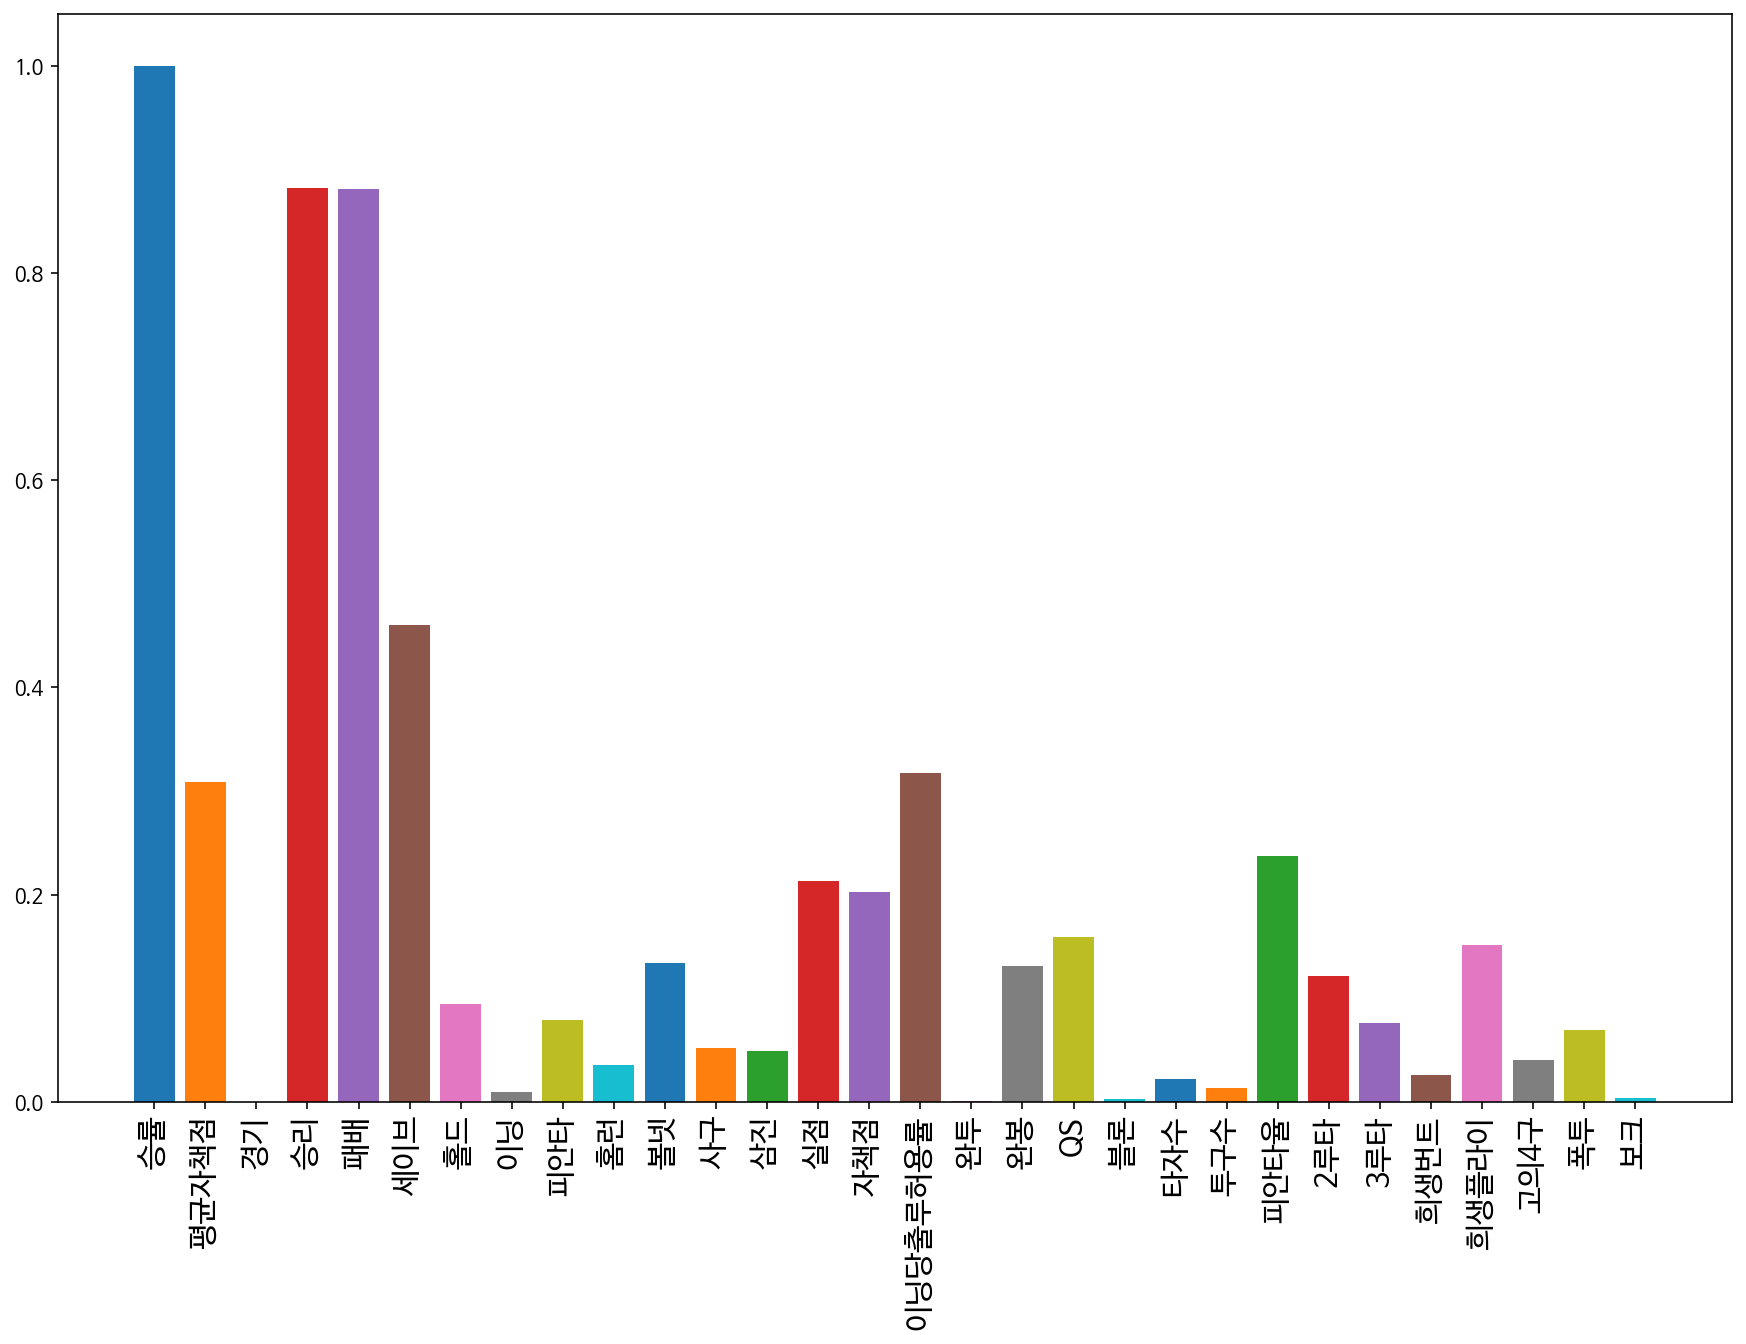

In [ ]:
# 다른 변수들과 품질에 대한 선형 회귀 분석 후 R² 기준으로 바차트를 그리시오
cols = target_pit.columns
plt.figure( figsize=(15,10) )

for col in cols :
  model = sm.OLS( target_pit['승률'], sm.add_constant( target_pit[ col ] ) )
  result = model.fit()
  plt.bar( [ col ], result.rsquared, label=col)
plt.xticks( fontsize=15, rotation=90 )
plt.show()

# 다중회귀분석

In [ ]:
sns.set(style='whitegrid')
plt.rc('font', family='NanumBarunGothic') 
sns.pairplot(target_pit[ cols ], height =2.5)
plt.show()

KeyboardInterrupt: ignored

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x7f6fecde8378> (for post_execute):


KeyboardInterrupt: ignored

In [ ]:
corr_tmp = np.corrcoef(target_pit.values)
corr_tmp

In [ ]:
target_pit.values.T

In [ ]:
corr_tmp = np.corrcoef(target_pit.values.T)
corr_tmp

## 후진제거법

In [ ]:
columns = target_pit.columns[1:]

In [ ]:
target_df = target_pit[columns]
target_df.head()

In [ ]:
y_data = target_pit['승률']
y_data.head()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(target_df, y_data, train_size=0.7, random_state=1)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

In [ ]:
X_train_added = sm.add_constant(X_train)
X_train_added.head()

In [ ]:
full_model = sm.OLS(y_train, X_train_added)
full_model_res = full_model.fit()

In [ ]:
print(full_model_res.summary())

In [ ]:
print(f'{"제거된 컬럼":15} {"R제곱값":20} {"다중공선성":20}')
print("="*77)
for idx in range(len(columns)) :
  tmp = list(columns)
  rm_col = tmp.pop(idx)
  m_model = sm.OLS(y_train, sm.add_constant(X_train[tmp]))
  m_model_res = m_model.fit()
  vif = 1/(1-m_model_res.rsquared)
  print(f'{rm_col:15} {m_model_res.rsquared:20} {vif:20}')

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(
    X_train.values, i) for i in range(X_train.shape[1])]
vif["features"] = X_train.columns
vif

In [ ]:
X_train.drop(['평균자책점', '경기', '승리', '패배', '이닝', '피안타','볼넷', '실점', '자책점', '이닝당출루허용률', '타자수', '투구수', '피안타율'], axis=1, inplace=True)

In [ ]:
columns = X_train.columns

In [ ]:
X_train_added = sm.add_constant(X_train)
X_train_added.head()

In [ ]:
full_model = sm.OLS(y_train, X_train_added)
full_model_res = full_model.fit()

In [ ]:
print(full_model_res.summary())

In [ ]:
print(f'{"제거된 컬럼":15} {"R제곱값":20} {"다중공선성":20}')
print("="*77)
for idx in range(len(columns)) :
  tmp = list(columns)
  rm_col = tmp.pop(idx)
  m_model = sm.OLS(y_train, sm.add_constant(X_train[tmp]))
  m_model_res = m_model.fit()
  vif = 1/(1-m_model_res.rsquared)
  print(f'{rm_col:15} {m_model_res.rsquared:20} {vif:20}')

In [ ]:
target_df = target_pit[columns]
y_data = target_pit['승률']
X_train, X_test, y_train, y_test = train_test_split(target_df, y_data, train_size=0.7, random_state=1)

In [ ]:
X_train.drop(['승리', '패배', '세이브', '홀드', '피안타', '홈런', '볼넷', '사구', '삼진', '실점', '완투', '완봉', 'QS','블론','2루타','3루타','희생번트','희생플라이','고의4구','폭투','보크'], axis=1, inplace=True)
X_train_added = sm.add_constant(X_train)
columns = X_train.columns[1:]

In [ ]:
full_model = sm.OLS(y_train, X_train_added)
full_model_res = full_model.fit()
print(full_model_res.summary())

In [ ]:
print(f'{"제거된 컬럼":15} {"R제곱값":20} {"다중공선성":20}')
print("="*77)
for idx in range(len(columns)) :
  tmp = list(columns)
  rm_col = tmp.pop(idx)
  m_model = sm.OLS(y_train, sm.add_constant(X_train[tmp]))
  m_model_res = m_model.fit()
  vif = 1/(1-m_model_res.rsquared)
  print(f'{rm_col:15} {m_model_res.rsquared:20} {vif:20}')

# 시계열


In [ ]:
kbo_pit_df

In [ ]:
result = kbo_pit_df

In [ ]:
# 선수별 고유 아이디 부여
info = result[['팀명', '팀명']].apply(lambda x: tuple(x), axis=1)

player_id = {}
for i,j in enumerate(info.unique()):
    player_id[j] = i
    
result['ID'] = result.apply(lambda x: player_id[tuple([x['팀명'], x['팀명']])], axis=1)

In [ ]:
result

In [ ]:
# Find correlations with the target and sort
correlations = result.corr()['승률'].sort_values()

In [ ]:
# Display correlations
print('Most Positive Correlations:\n', correlations.tail(11))
print('\nMost Negative Correlations:\n', correlations.head(10))

In [ ]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(15,8))

plt.bar(correlations.tail(11)[:-1].index.astype(str)[::-1], 100*correlations.tail(11)[:-1][::-1],color='r')

# Plot labeling
plt.xticks(rotation=75) ; plt.xlabel('Top 10 correlations'); plt.ylabel('Correlation (%)');
plt.title('Top 10 correlations with 승률')

In [ ]:
plt.figure(figsize=(15,8))

plt.bar(correlations.head(10)[2:].index.astype(str), 100*correlations.head(10)[2:])

# Plot labeling
plt.xticks(rotation=75) ; plt.xlabel('Low 8 correlations'); plt.ylabel('Correlation (%)')
plt.title('Low 8 correlations with 승률')

In [ ]:
#Top 5. High correlation with 'OPS' Pair Plot
print("Top 5. High correlation with 'OPS' Pair Plot")
high_corr = result.loc[:,list(correlations.tail(6)[::-1].index)]
sns.pairplot(high_corr,diag_kind='kde')
plt.show()

In [ ]:
# Top5. Low correlation with 'OPS' Pair Plot
print("Top5. Low correlation with 'OPS' Pair Plot")
low_corr = result.loc[:,['승률']+list(correlations.head(7)[2:].index)]
sns.pairplot(low_corr,diag_kind='kde')
plt.show()

In [ ]:
# 사용 features 명시
infos = ['팀명']
stats = ['평균자책점', '경기', '승리', '패배', '세이브', '홀드', '이닝', '피안타', '홈런', '볼넷', '사구', '삼진', '실점', '자책점', '이닝당출루허용률', \
         '완투', '완봉', 'QS', '블론', '타자수', '투구수', '피안타율', '2루타', '3루타', '희생번트', '희생플라이', '고의4구', '폭투', '보크']

# 해당 시즌 이전까지의 누적 기록
def get_cumulative(player_id, season, stat=stats ,df=result):
    try:
        result_cum = df[(df['팀명']==player_id) & (df['연도'] == season)][stat]
        result_cum = result_cum.mean()
        
    except:
        result_cum = [np.nan for i in stat]
        result_cum = pd.Series(result_cum)
    
    return result_cum

In [ ]:
# 모든 stats에 대한 누적 stat
stats_cum = [i + '_누적' for i in stats]

# 누적 stat 데이터프레임에 반영
result[stats_cum] = result.apply(lambda x: get_cumulative(x['팀명'], x['연도']), axis=1)

In [ ]:
# lag stat (직전 몇년의 기록)
def get_lag(player_id, season, lag, stat=stats, df=result):
    try:
        result_lag = df[(df['팀명']==player_id)&(df['연도'] == season-lag)][stat].values[0]
        result_lag = pd.Series(result_lag)
        
    except:
        result_lag = [np.nan for i in stat]
        result_lag = pd.Series(result_lag)
        
    return result_lag

In [ ]:
# 직전 1,2,3년의 기록
stats_lag1 = [i + '_LAG1' for i in stats]
stats_lag2 = [i + '_LAG2' for i in stats]
stats_lag3 = [i + '_LAG3' for i in stats]

In [ ]:
# lag1
result[stats_lag1] = result.apply(lambda x: get_lag(x['팀명'],x['연도'], lag=1), axis=1)
# lag2
result[stats_lag2] = result.apply(lambda x: get_lag(x['팀명'],x['연도'], lag=2), axis=1)
# lag3
result[stats_lag3] = result.apply(lambda x: get_lag(x['팀명'],x['연도'], lag=3), axis=1)

In [ ]:
# 내년 기록 (OPS, 장타, 출루)
# 데이터 프레임의 정답 셋 만들기 위함

def get_next_year(player_id, season, stat=['평균자책점', '실점', '승률'],df=result):
    try:
        result = df[(df['팀명']==player_id)&(df['연도']==season+1)][stat].values[0]
        result = pd.Series(result)
    except:
        result = [np.nan for i in stat]
        result = pd.Series(result)
        
    return result

In [ ]:
# 장타, 출루, OPS의 내년 기록
stats_next = [i + '_NEXT' for i in ['평균자책점', '실점', '승률']]
result[stats_next] = result.apply(lambda x: get_next_year(x['팀명'], x['연도']), axis=1)

In [ ]:
result[stats_next]

In [ ]:
from IPython.display import clear_output

In [ ]:
from xgboost import XGBRegressor, plot_importance
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.linear_model import Ridge, Lasso, LinearRegression, ElasticNet
from sklearn.neighbors import KNeighborsRegressor

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [ ]:
df = result.fillna(-1) # nan값 -1로 impute 
df = df[df['승률_NEXT'] != 0] # 다음 해의 OPS가 존재하는 값들만 추출 (다음 해 OPS 가 없다면, predict 값과 target값을 비교 할 수 없기 때문)

In [ ]:
df